In [1]:
import random
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

import sys
sys.path.insert(0, '..')
from utils.latex import add_colname, show_latex, TABLES
from utils.config import PATHS
from utils.data_process import concat_annotated, drop_disregard, fix_week_14

In [2]:
pd.set_option('max_columns', None)
pd.set_option('max_colwidth', None)

# Load data

In [3]:
# load and concatenate annotations
path = PATHS.getpath('data_expr_sept')
df = concat_annotated(path)

In [4]:
# load batch info
path = PATHS.getpath('data_to_inception_conll')
info = pd.concat([pd.read_pickle(fp) for fp in path.glob('week_*.pkl')], ignore_index=True)

In [5]:
df = df.merge(
    info[['NotitieID', 'MDN', 'source', 'samp_meth']],
    how='left',
    on=['NotitieID', 'MDN'],
)

# Annotated notes

In [6]:
caption = "Weeks 14-34: Number of annotated notes (incl. disregard)"
label = "w14-w34_annot_n_notes"

df.pivot_table(
    index='source',
    values='NotitieID',
    aggfunc='nunique',
    margins=True,
    margins_name='total',
).rename(columns={'NotitieID': 'n_notes'}
).join(
        df.query("disregard == True").pivot_table(
        index='source',
        values='NotitieID',
        aggfunc='nunique',
        margins=True,
        margins_name='total',
    ).rename(columns={'NotitieID': 'n_disregard'})
).assign(
    n_annotated=lambda df: df.n_notes - df.n_disregard,
    prc_disregard=lambda df: (df.n_disregard / df.n_notes).mul(100).round(1),
).pipe(show_latex, caption=caption, label=label)

,n_notes,n_disregard,n_annotated,prc_disregard
source,,,,
2017,"1,262",173,"1,089",13.7
2018,"1,225",172,"1,053",14.0
cov_2020,"2,399",59,"2,340",2.5
non_cov_2020,"1,278",206,"1,072",16.1
total,"6,164",610,"5,554",9.9


# Annotated sentences

In [7]:
# remove "disregard" notes & remove MBW annotations from week 14
adjusted = drop_disregard(df).pipe(fix_week_14)

# select rows with domain labels
domains = ['ADM', 'ATT', 'BER', 'ENR', 'ETN', 'FAC', 'INS', 'MBW', 'STM']
rows_with_domain = adjusted.loc[adjusted[domains].any(axis=1)]
domain_totals_per_sen_id = rows_with_domain.groupby(['source', 'sen_id'])[domains].any()

In [8]:
caption = "Weeks 14-34: Number of sentences with domain labels (excl. disregard)"
label = "w14-w34_annot_sents_w_domain_labels"

n_sent = adjusted.groupby('source').sen_id.nunique()

n_sent_with_label = adjusted.assign(
    has_domain = lambda df: df[domains].any(axis=1),
).query("has_domain == True").groupby('source').sen_id.nunique()

table = pd.concat([
    n_sent.rename('n_all_sents'),
    n_sent_with_label.rename('n_sents_with_labels'),
], axis=1)
table.loc['total'] = table.sum()
table.assign(prc_sents_with_labels=lambda df: (df.n_sents_with_labels / df.n_all_sents).mul(100).round(1)
).pipe(show_latex, caption=caption, label=label)

,n_all_sents,n_sents_with_labels,prc_sents_with_labels
source,,,
2017,"52,454","2,339",4.5
2018,"53,187","2,249",4.2
cov_2020,"124,418","7,803",6.3
non_cov_2020,"56,056","2,295",4.1
total,"286,115","14,686",5.1


# Distribution of domains

In [9]:
caption = "Weeks 14-34: Distribution of domains"
label = "w14-w34_annot_domains"

n_labels = domain_totals_per_sen_id.pivot_table(
    index='source',
    values=domains,
    aggfunc='sum',
    margins=True,
    margins_name='total',
).assign(total=lambda df: df.sum(axis=1))

p_labels = (n_labels.div(n_labels.iloc[:, -1], axis=0) * 100).round()
26
piv = n_labels.pipe(add_colname, 'n').join(
    p_labels.pipe(add_colname, '%')
).astype('Int64'
).sort_index(axis=1, level=[0,1], ascending=[True, False])

piv.pipe(show_latex, caption=caption, label=label)

ADM      ATT     BER       ENR       ETN        FAC      \
                  n   %    n  %    n  %      n  %      n   %      n   %   
source                                                                    
2017            567  23   58  2   59  2    221  9    527  21    246  10   
2018            597  25   41  2   66  3    194  8    501  21    274  11   
cov_2020      3,940  47  142  2   91  1    591  7  1,376  17    541   7   
non_cov_2020    700  29   60  2   52  2    186  8    419  17    257  11   
total         5,804  37  301  2  268  2  1,192  8  2,823  18  1,318   8   

                INS      MBW        STM       total       
                  n   %    n   %      n   %       n    %  
source                                                    
2017            187   7  253  10    389  16   2,507  100  
2018            232  10  198   8    308  13   2,411  100  
cov_2020        694   8  314   4    626   8   8,315  100  
non_cov_2020    214   9  150   6    395  16   2,433  100  
total         1,327   8  915   6  1,718  11  15,666  100

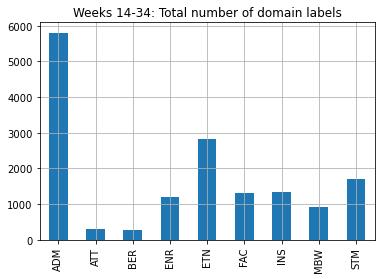

In [10]:
# total number of labels

fig, ax = plt.subplots(figsize=(6, 4))
piv.loc[['total']].xs('n', axis=1, level=1).iloc[:,:-1].T.plot.bar(
    ax=ax,
    legend=False, 
    grid=True, 
    title='Weeks 14-34: Total number of domain labels',
)
fig.savefig('figures/w14-w34_total_n_domains.png')

# Distribution of levels per domain

In [11]:
caption = "Weeks 14-34: Distribution of levels per domain"
label = "w14-w34_annot_levels"

stats = []
for lvl in [f"{i}_lvl" for i in domains]:
    notna = adjusted.loc[adjusted[lvl].notna()]
    stat = notna.groupby(['source', 'sen_id'])[lvl].apply(lambda s: {i for i in s if i==i})
    stat = stat.explode().groupby(level=0).value_counts()
    stats.append(stat)
table = pd.concat(stats, axis=1)
table = table.append(pd.concat([table.groupby(level=1).sum()], keys=['total']))
table.index = pd.MultiIndex.from_tuples([(i,int(j)) for i,j in table.index])
# sums = table.groupby(level=0).sum()
# sums.index = pd.MultiIndex.from_tuples([(i, 'total') for i in sums.index])
# table = pd.concat([table, sums]).sort_index(level=0)
table.pipe(show_latex, caption=caption, label=label)

ADM_lvl ATT_lvl BER_lvl ENR_lvl ETN_lvl FAC_lvl INS_lvl  \
2017         0     56.0     1.0    16.0     6.0    52.0      15       6   
             1     79.0     1.0     1.0    51.0   202.0       8      41   
             2    109.0    26.0     7.0   132.0   157.0      13      55   
             3    109.0     6.0     7.0    25.0    41.0      27      46   
             4    267.0    25.0    30.0     8.0   100.0     159      14   
             5      nan     nan     nan     nan     nan      32      33   
2018         0     29.0     3.0    10.0     4.0    60.0       8       5   
             1     78.0     6.0     4.0    51.0   182.0       7      38   
             2    117.0    10.0    16.0   113.0   155.0      24      75   
             3    140.0     5.0     1.0    14.0    40.0      23      60   
             4    279.0    18.0    35.0    12.0    90.0     180      25   
             5      nan     nan     nan     nan     nan      46      40   
cov_2020     0    904.0     7.0    35.0    31.0   279.0      68      68   
             1  1,259.0    14.0     4.0   215.0   346.0      28     237   
             2    697.0    75.0    17.0   289.0   474.0      30     231   
             3    686.0    17.0     6.0    45.0   115.0     106     133   
             4    769.0    35.0    32.0    24.0   221.0     277      33   
             5      nan     nan     nan     nan     nan      49      21   
non_cov_2020 0     29.0     4.0    16.0    11.0    39.0      28      11   
             1    115.0     8.0     3.0    48.0   111.0       6      56   
             2    146.0    28.0    10.0   105.0   106.0      15      71   
             3    122.0    10.0     2.0    15.0    56.0      41      40   
             4    359.0    10.0    19.0    19.0   130.0     158      22   
             5      nan     nan     nan     nan     nan      19      30   
total        0  1,018.0    15.0    77.0    52.0   430.0     119      90   
             1  1,531.0    29.0    12.0   365.0   841.0      49     372   
             2  1,069.0   139.0    50.0   639.0   892.0      82     432   
             3  1,057.0    38.0    16.0    99.0   252.0     197     279   
             4  1,674.0    88.0   116.0    63.0   541.0     774      94   
             5      0.0     0.0     0.0     0.0     0.0     146     124   

               MBW_lvl STM_lvl  
2017         0     3.0    23.0  
             1    46.0    54.0  
             2    91.0   167.0  
             3    59.0    72.0  
             4    65.0    93.0  
             5     nan     nan  
2018         0     2.0     2.0  
             1    43.0    42.0  
             2    69.0   136.0  
             3    31.0    59.0  
             4    57.0    75.0  
             5     nan     nan  
cov_2020     0     7.0    33.0  
             1    96.0    84.0  
             2    78.0   283.0  
             3    45.0   107.0  
             4    95.0   150.0  
             5     nan     nan  
non_cov_2020 0     5.0    18.0  
             1    33.0    70.0  
             2    37.0   166.0  
             3    25.0    74.0  
             4    51.0    80.0  
             5     nan     nan  
total        0    17.0    76.0  
             1   218.0   250.0  
             2   275.0   752.0  
             3   160.0   312.0  
             4   268.0   398.0  
             5     0.0     0.0

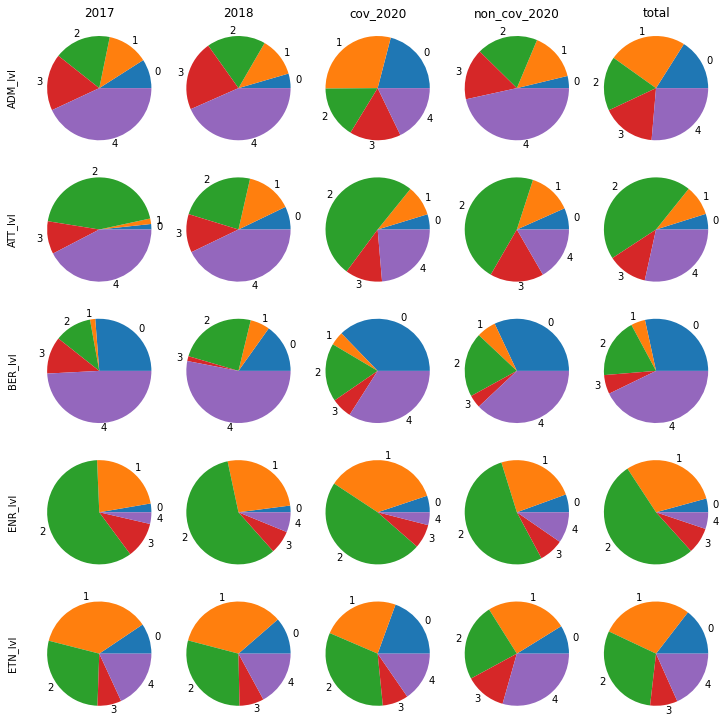

In [12]:
cols = table.index.levels[0]
rows = table.columns[:5]
nrows = len(rows)
ncols = len(cols)
fig, axes = plt.subplots(nrows, ncols, figsize=(2*ncols,2*nrows), constrained_layout=True)

for i, row in enumerate(rows):
    for j, col in enumerate(cols):
        ylabel = row if j == 0 else ''
        table.xs(col)[row].plot.pie(ax=axes[i,j])
        axes[i,j].set_ylabel(ylabel=ylabel, labelpad=16)
for ax, col in zip(axes[0], cols):
    ax.set_title(col)

fig.savefig('figures/w14-w34_levels_part1.png')

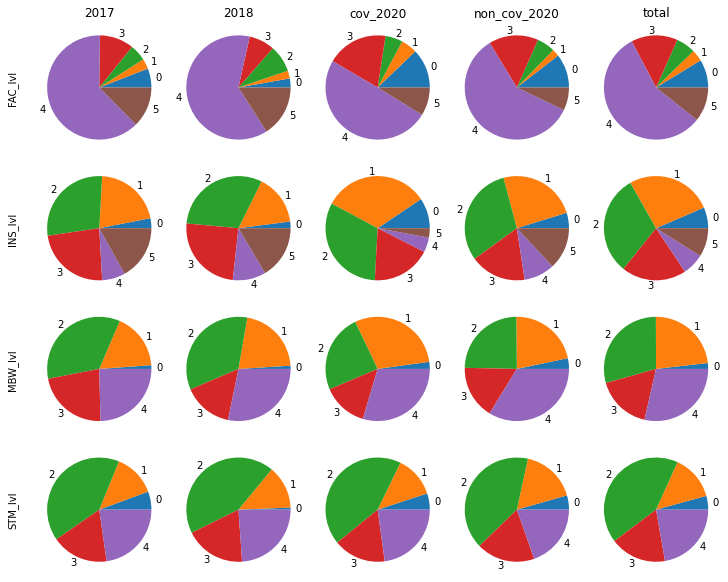

In [13]:
cols = table.index.levels[0]
rows = table.columns[5:]
nrows = len(rows)
ncols = len(cols)
fig, axes = plt.subplots(nrows, ncols, figsize=(2*ncols,2*nrows), constrained_layout=True)

for i, row in enumerate(rows):
    for j, col in enumerate(cols):
        ylabel = row if j == 0 else ''
        table.xs(col)[row].plot.pie(ax=axes[i,j])
        axes[i,j].set_ylabel(ylabel=ylabel, labelpad=16)
for ax, col in zip(axes[0], cols):
    ax.set_title(col)

fig.savefig('figures/w14-w34_levels_part2.png')

# Levels aggregated on a note-level

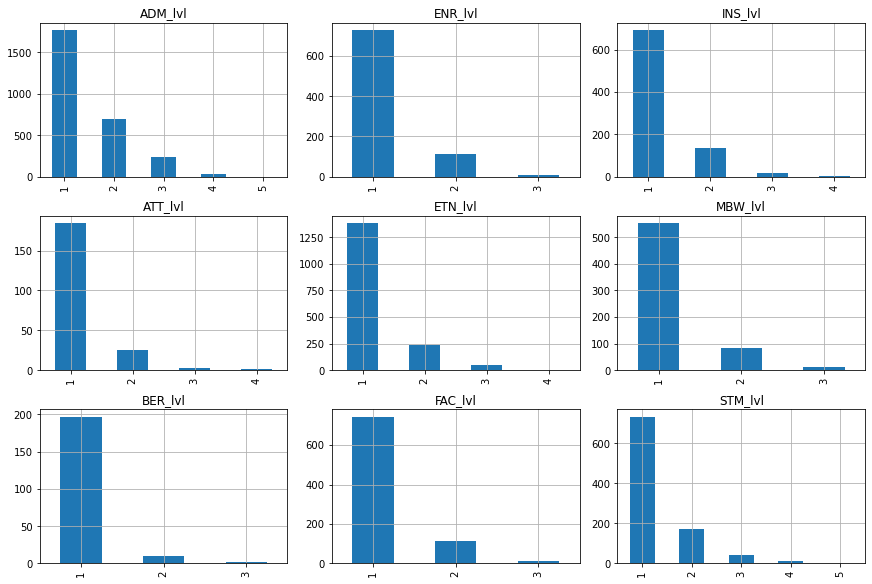

In [14]:
fig, axes = plt.subplots(3, 3, figsize=(12, 8), constrained_layout=True)
for i, lev in enumerate([f'{d}_lvl' for d in domains]):
    x, y = i%3, i//3
    s = adjusted.groupby('NotitieID')[lev].nunique().loc[lambda s: s>0]
    s.value_counts().plot.bar(ax=axes[x,y], grid=True)
    axes[x,y].set_title(lev)

fig.savefig('figures/w14-w34_dist_nunique_levels_per_note.png')

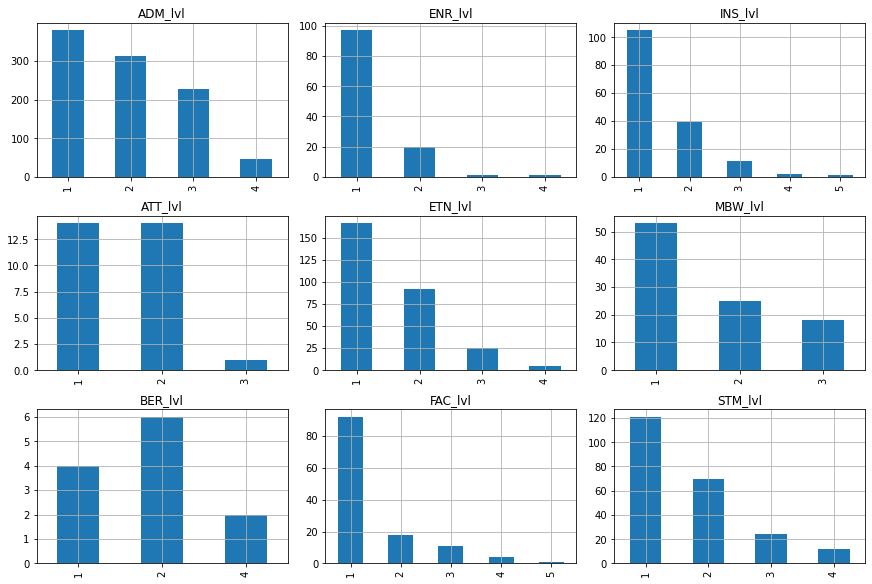

In [15]:
fig, axes = plt.subplots(3, 3, figsize=(12, 8), constrained_layout=True)
for i, lev in enumerate([f'{d}_lvl' for d in domains]):
    x, y = i%3, i//3
    to_agg = ['nunique', 'min', 'max']
    sel_rows = lambda df: df['nunique'] > 1
    s = adjusted.groupby('NotitieID')[lev].agg(to_agg).loc[sel_rows]
    diff = (s['max'] - s['min']).astype(int)
    diff.value_counts().sort_index().plot.bar(ax=axes[x,y], grid=True)
    axes[x,y].set_title(lev)

fig.savefig('figures/w14-w34_dist_diff_minmax_levels_per_note.png')

# Randomly-selected notes vs. Keyword-selected notes

In [16]:
# % disregard notes (out of all notes)
compare_samp = df.assign(
    samp_meth=lambda df: df.samp_meth.str.split('_').str[0]
).groupby(['samp_meth']).apply(
    lambda grp: grp.groupby('NotitieID').disregard_note.first().agg({'n':'size', 'p':'sum'})
)
pct_disregard = (compare_samp.p / compare_samp.n).mul(100).round(1).rename(r'% disregard notes')

# % sentences with labels (out of all sents, excl. disregard)
adjusted = adjusted.assign(
    samp_meth=lambda df: df.samp_meth.str.split('_').str[0]
)
n_sents = adjusted.groupby('samp_meth').sen_id.nunique()

n_sents_with_label = adjusted.assign(
    has_domain = lambda df: df[domains].any(axis=1),
).query("has_domain == True").groupby('samp_meth').sen_id.nunique()

pct_sents_with_label = (n_sents_with_label / n_sents).mul(100).round(1).rename(r'% sentences with labels')

# distribution of domains
rows_with_domain = adjusted.loc[adjusted[domains].any(axis=1)]
domain_totals_per_sen_id = rows_with_domain.groupby(['samp_meth', 'sen_id'])[domains].any()

n_labels = domain_totals_per_sen_id.pivot_table(
    index='samp_meth',
    values=domains,
    aggfunc='sum',
).assign(total=lambda df: df.sum(axis=1))

pct_labels = (n_labels.div(n_labels.iloc[:, -1], axis=0) * 100).round(1).iloc[:,:-1]

# put everything together
caption = "Weeks 14-34: Comparison between randomly-selected and keyword-selected notes"
label = "w14-w34_annot_kwd_vs_rndm"

pd.concat([pct_disregard, pct_sents_with_label, pct_labels], axis=1).T.pipe(show_latex, caption=caption, label=label)

samp_meth,kwd,rndm
% disregard notes,10.4,8.4
% sentences with labels,5.2,4.8
ADM,37.0,37.7
ATT,2.1,0.8
BER,1.7,1.8
ENR,7.7,6.8
ETN,17.6,20.9
FAC,8.3,9.4
INS,8.5,8.0
MBW,6.0,4.8


In [17]:
prefix = 'w14-w34_annot'
for idx, table in enumerate(TABLES):
    with open(f'./tables/{prefix}_{idx}.tex', 'w', encoding='utf8') as f:
        f.write(table)